# CLIMADA - RIM2D data flow: EXAMPLE 1

In this notebook we show one simple impact calculations with CLIMADA using a datafile for a **SINGLE** flood event from the RIM2D model.

The possible flood events to choose from are

*Coastal:*
- Coastal_2013Storm_wd_max.asc (2013 Bodil storm)
- Coastal_100yPresent_wd_max.asc (100y present)
- Coastal_100ySSP2-4.5_wd_max.asc (Future 100y RCP 4.5)

*Pluvial:*
- pluvial_100yPresent_wd_max.asc (100y present)
- pluvial_100yRCP4-5_wd_max.asc (Future 100y RCP 4.5)


In [16]:
from pathlib import Path

**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [2]:
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

# Define the output folder path (used later in the script)
output_path = Path('Results')

# Create the output folder if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

### Define the Hazard Object

*Note: The data provided by Rim2D is in ASC format, which is not commonly used by CLIMADA users. Ideally, data should be provided in NetCDF or xarray format.*

Given the ASC format from Rim2D, we will define the Hazard object [manually](https://climada-python.readthedocs.io/en/stable/tutorial/climada_hazard_Hazard.html#part-3-define-hazards-manually) instead of using a class method to read a NetCDF file ( see *CLIMADA-PIK_example1.ipynb*).

- First, we convert the raster data to a GeoDataFrame to generate the centroids for the hazard object.
- We can use GeoPandas to reproject the data from its current CRS (given manually and not available in the .asc) to the default reference system, "EPSG:4326".
- It is crucial to ensure that both the exposure and hazard objects are in the same coordinate system later on.


In [3]:
import numpy as np
import geopandas as gpd
from scipy.sparse import csr_matrix
from climada.hazard import Hazard, Centroids

# Define the file path and parameters
folder = 'RIM2D/Denmark_results'  # Folder where the file is located
file = 'Coastal_100yPresent_wd_max.asc'  # Name of the hazard file. We also have: Coastal_2013Storm_wd_max.asc, Coastal_100yPresent_wd_max.asc, Coastal_100ySSP2-4.5_wd_max.asc
hazard_type = 'RF'  # Type of the hazard, ideally a two-letter identifier
intensity_unit = 'm'  # Unit of intensity, just for plots
n_ev = 1  # Number of events
frequency = np.ones(n_ev) / 1000  # Arbitrary frequency of the event
orig_crs = "EPSG:25832"  # CRS needs to be provided manually as it cannot be read from the .asc file!!!
intended_crs = "EPSG:4326"  # CLIMADA default CRS
file_path = data_path / folder / file  # Complete file path

# Read the .asc file
with open(file_path, 'r') as file:
    header = {}
    header['ncols'] = int(file.readline().split()[1])
    header['nrows'] = int(file.readline().split()[1])
    header['xllcorner'] = float(file.readline().split()[1])
    header['yllcorner'] = float(file.readline().split()[1])
    header['cellsize'] = float(file.readline().split()[1])
    header['nodata_value'] = float(file.readline().split()[1])
    data = np.loadtxt(file, skiprows=0)

# Convert the raster data to a GeoDataFrame
nrows, ncols = data.shape
x_coords = np.linspace(header['xllcorner'], header['xllcorner'] + (ncols - 1) * header['cellsize'], ncols)
y_coords = np.linspace(header['yllcorner'], header['yllcorner'] + (nrows - 1) * header['cellsize'], nrows)
X, Y = np.meshgrid(x_coords, y_coords)
xx = X.flatten()
yy = Y.flatten()
values = data.flatten()  # Flatten the data to align with the coordinates

# Create a GeoDataFrame with the values and geometry
haz_gdf = gpd.GeoDataFrame({'value': values}, geometry=gpd.points_from_xy(xx, yy), crs=orig_crs)

# Reproject the GeoDataFrame to the intended CRS
haz_gdf = haz_gdf.to_crs(intended_crs)

# Create the hazard object
haz = Hazard(
    haz_type=hazard_type,
    intensity=csr_matrix([haz_gdf["value"]]),  # Sparse matrix with the intensity of the event
    centroids=Centroids(lat=haz_gdf.geometry.y, lon=haz_gdf.geometry.x, crs=haz_gdf.crs),
    units=intensity_unit,
    event_id=np.arange(n_ev, dtype=int),
    frequency=frequency
)

# Check the hazard object
haz.check()


### Define the Exposure Object

We will now define the exposure object using the provided building shapefile.

Since the shapefile does not include specific values for the exposure, we will arbitrarily set these values to one.

In [4]:
from climada.entity import Exposures

# Parameters
folder = 'RIM2D/Denmark_results/buildings_denmark'
file = 'buildings_denmark.shp'

# Folder where the file is located
shape_file = data_path / folder / file

# Load the shapefile into a GeoDataFrame
exp_gdf = gpd.read_file(shape_file)

# Check the CRS (Coordinate Reference System)
print("Origin CRS:", exp_gdf.crs)
exp_gdf = exp_gdf.to_crs(intended_crs) # Convert the crs to the intended crs

# Add a 'value' column to the GeoDataFrame and set all values arbitrarily to 1
exp_gdf['value'] = np.ones(len(exp_gdf))

# Display the first few rows of the GeoDataFrame
print(exp_gdf.head())

# Define the exposure object
exp = Exposures(exp_gdf)

Origin CRS: EPSG:25832
                                           inspireid  dateofreno  dateofdemo  \
0  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
1  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
2  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
3  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
4  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   

   dateofcons  conditiono               beginlifes  endlifespa  numberoffl  \
0         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
1         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
2         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
3         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
4         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   

   numberofbu  numberofdw  

### Define the impact function

array([<Axes: title={'center': 'RF 1: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
       <Axes: title={'center': 'RF 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
      dtype=object)

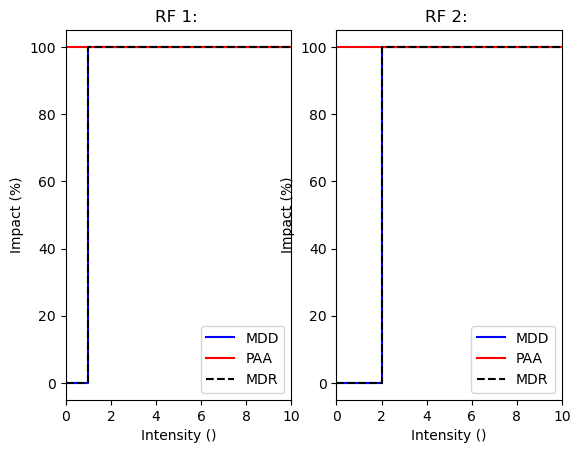

In [5]:
from climada.entity import ImpactFunc, ImpactFuncSet
min_depth = 0
max_depth = 10

# Impact function 1 with a step function 0 to 1 with a threshold starting at 1
threshold1 = 1
impf_id1 = 1
impf1 = ImpactFunc.from_step_impf(
    intensity=(min_depth, threshold1, max_depth),
    haz_type=hazard_type,
    impf_id=impf_id1
)

# Impact function 2 with a step function 0 to 1 with a threshold starting at 2
threshold2 = 2
impf_id2 = 2
impf2 = ImpactFunc.from_step_impf(
    intensity=(min_depth, threshold2, max_depth),
    haz_type=hazard_type,
    impf_id=impf_id2
)

impfset = ImpactFuncSet([impf1, impf2])

#  Plot the impact functions
impfset.plot()

Now, we need to assign the impact functions to the exposure points. To simplify the example and see how many buidling where impacted with a water level greater than 1 m we use only impf_id1

In [6]:
exp.gdf[f'impf_{hazard_type}'] = impf_id1 # Assign the impact function to the exposure object with threshold 1

### Calculate the Impact

Given the high resolution of the hazard and exposure object, which is finer than what is typically used in CLIMADA, we will calculate the impact per building (represented by polygons) using two different approaches. This allows us to compare the differences in results.

#### Two-Step Impact Calculation:

1. **Rasterization Approach**:
   - Divide each building into grid points.
   - Distribute the building’s value equally among these grid points.
   - Use a nearest-neighbor approach (with a specified distance tolerance) to calculate the impact.
   - See CLIMADA tutorial [how-to-use-polygons-or-lines-as-exposure](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures_polygons_lines.html#how-to-use-polygons-or-lines-as-exposure)

2. **Buffer Approach**:
   - Create a 20-meter buffer zone around each building.
   - Calculate the average water level within this buffer.
   - Represent each building by a centroid and project the average water level onto that centroid.
   - Approach inspired by SAFERPLACES

By applying these two methods, we can evaluate the differences in impact calculation due to resolution and spatial representation.
The impact calculations are stored in an [Impact object](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_Impact.html#impact-class-data-structure)

Below is an illustrative figure of the water distribution around a building (white square):

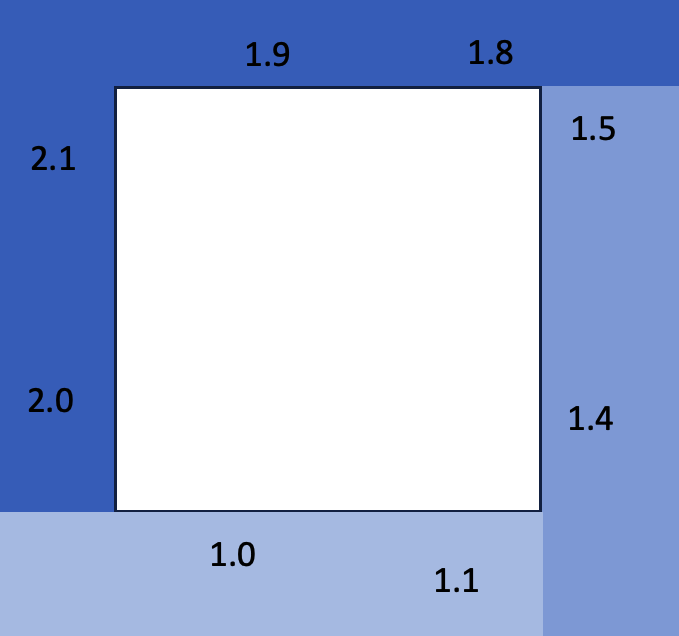

#### Calculate the impact - Rasterization

In [7]:
import climada.util.lines_polys_handler as u_lp

imp_rast = u_lp.calc_geom_impact(
    exp=exp, # Exposure object
    impf_set=impfset, # Impact function set
    haz=haz, # hazard object
    res= 1, # Resolution of the grid in meters (Don't know the max resolution) :/)
    to_meters=True, # If True, res is interpreted as meters
    disagg_met=u_lp.DisaggMethod.DIV,  # Disaggregation method – can be either fixed (FIX), replicating the original shape’s value onto all points, or divided evenly (DIV), in which case the value is divided equally onto all new points. 
    disagg_val=None, # Disaggregation value, the source (and number) of the value to be distributed
    agg_met=u_lp.AggMethod.SUM # Aggregation method ( can currently be only (SUM) were the value is summed over all points in the geometry)
)

# imp_rast: Impact object with the impact per geometry (rows of exp.gdf). Contains two additional attributes 'geom_exp' and 'coord_exp', the first one being the origninal line or polygon geometries for which impact was computed.

2024-08-28 16:52:06,739 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:06,882 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:07,256 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:07,616 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:12,518 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:13,185 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:23,900 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2024-08-28 16:52:23,963 - climada.util.lines_pol

/Users/vwattin/Documents/Programming/Climate/climada_python/climada/util/lines_polys_handler.py:617: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  group = gdf_pnts.groupby(axis=0, level=0)


In [8]:
# Print the total impact value for the event
print(f'The impact using the rasterization method: {imp_rast.at_event}') # The impact using the rasterization method

# Print the number of cells with impact values greater than 0
print(f'The number of buildings impacted by water level above {threshold1}m: {(imp_rast.imp_mat.toarray() > 0).sum()}')


The impact using the rasterization method: 9997.182645783685
The number of buildings impacted by water level above 1m: 10130


## Use the 20meter buffer method

To account for varying water levels around each building, we create a 20-meter buffer zone around each building polygon and calculate the average water level within this zone (excluding the zone occupied by the building). The process involves:

1. **Buffer Creation**: Draw a 20-meter buffer around each building polygon.
2. **Dummy Centroid Representation**: Represent each building with a dummy centroid point.
3. **Water Level Calculation**: For each building, identify hazard centroids within the buffer (excluding the building area) and compute the average water level.
4. **New Hazard Object**: Create a hazard object where the intensity at each dummy centroid reflects the average water level.
5. **New Exposure Object**: Represent buildings by their corresponding dummy centroids in the new exposure object.
6. **Impact Calculation**: Calculate the impact using the new hazard and exposure objects.

By using dummy centroids instead of building polygons, we simplify the exposure representation while incorporating spatial variations in water levels.


In [9]:
import time
import geopandas as gpd

# Parameters
buffer_dist = 20  # Buffer distance in meters

# Make a copy of the original GeoDataFrame in exposure
exp_dummy_gdf = exp.gdf.copy()

# Check if the CRS is EPSG:4326
if exp_dummy_gdf.crs != "EPSG:4326":
    raise ValueError("The GeoDataFrame CRS is not 'EPSG:4326'. Please reproject it to 'EPSG:4326' before applying this function.")

# Convert 20 meters to degrees for latitude and longitude
lat_conversion_factor = 111320  # meters per degree latitude
lon_conversion_factor = 111320 * np.cos(np.radians(exp_dummy_gdf.geometry.centroid.y.mean()))  # meters per degree longitude at the average latitude
# Convert buffer distance to degrees
buffer_dist_lat = buffer_dist / lat_conversion_factor
buffer_dist_lon = buffer_dist / lon_conversion_factor

# Create a buffer around the single point geometry
exp_dummy_gdf['geometry_buffert'] = exp_dummy_gdf['geometry'].buffer(buffer_dist_lat)
exp_dummy_gdf['geometry_original'] = exp_dummy_gdf['geometry']  # Save the original geometry for later

# Add a column to the GeoDataFrame such that each polygon is represented by a point instead of the original polygon
exp_dummy_gdf['geometry'] = exp_dummy_gdf['geometry'].centroid

# Create a GeoDataFrame for the hazard centroids
haz_centroid_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(haz.centroids.lon, haz.centroids.lat))
# Ensure the centroids GeoDataFrame and polygon GeoDataFrame are in the same CRS
haz_centroid_gdf.crs = exp_dummy_gdf.crs

# Function to get hazard centroids indices that are within the buffer zone
def get_centroids_inside(gdf, centroid_gdf, geometry_column):
    gdf = gdf.set_geometry(geometry_column)  # Set the specified geometry column as active
    joined = gpd.sjoin(centroid_gdf, gdf, how='left', op='within')
    grouped = joined.groupby('index_right').apply(lambda x: list(x.index)).reindex(gdf.index, fill_value=[])
    gdf = gdf.set_geometry('geometry')  # Reset to the original geometry column
    return grouped

# Get centroids within buffered and original geometries
exp_dummy_gdf['haz_centroid_indices_buffer'] = get_centroids_inside(exp_dummy_gdf, haz_centroid_gdf, 'geometry_buffert')  # Get the indices of the hazard centroids that are within the buffer zone
exp_dummy_gdf['haz_centroid_indices_original'] = get_centroids_inside(exp_dummy_gdf, haz_centroid_gdf, 'geometry_original')  # Get the indices of the hazard centroids that are within the original geometry

# Subtract to find centroids in the buffer but not in the original geometry
exp_dummy_gdf['haz_centroid_indices'] = exp_dummy_gdf['haz_centroid_indices_buffer'].apply(set) - exp_dummy_gdf['haz_centroid_indices_original'].apply(set)
exp_dummy_gdf['haz_centroid_indices'] = exp_dummy_gdf['haz_centroid_indices'].apply(list)

# Clean up temporary columns
exp_dummy_gdf.drop(columns=['geometry_buffert', 'haz_centroid_indices_buffer', 'haz_centroid_indices_original'], inplace=True)

# Print the first few rows of the updated GeoDataFrame
print(exp_dummy_gdf.head())

# Create the dummy exposure object
exp_dummy = Exposures(exp_dummy_gdf)

# Set the latitude and longitude for the exposure object
exp_dummy.set_lat_lon()

# Check the exposure object
exp_dummy.check()


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_75552/3713544121.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon_conversion_factor = 111320 * np.cos(np.radians(exp_dummy_gdf.geometry.centroid.y.mean()))  # meters per degree longitude at the average latitude
/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_75552/3713544121.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_dummy_gdf['geometry_buffert'] = exp_dummy_gdf['geometry'].buffer(buffer_dist_lat)
/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_75552/3713544121.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to

                                           inspireid  dateofreno  dateofdemo  \
0  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
1  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
2  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
3  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   
4  https://geo.data.gov.dk/dataset/3237298e-d65b-...         NaN         NaN   

   dateofcons  conditiono               beginlifes  endlifespa  numberoffl  \
0         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
1         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
2         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
3         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   
4         NaN  functional  2018/01/12 08:55:32.000         NaN         NaN   

   numberofbu  numberofdw  ... heightabov  name  \

Now, create a dummy hazard object based on the single point dummy centroids where the average water level in the bufferet zone is projected on each dummy centroid.   

In [10]:
import numpy as np
import copy
from scipy.sparse import csr_matrix

# Create a dummy intensity matrix
n_events = len(haz.event_id)
n_centroids = len(exp_dummy_gdf)
dummy_intensity_matrix = np.zeros((n_events, n_centroids))

# Copy the original intensity matrix
intensity_matrix = copy.deepcopy(haz.intensity.toarray())

# Iterate over each row in exp_dummy_gdf
for idx, row in exp_dummy_gdf.iterrows():
    centroid_indices = row['haz_centroid_indices']

    if centroid_indices:  # Ensure centroid_indices is not empty
        # Calculate the mean intensity for the centroids
        dummy_intensity_matrix[:, idx] = np.mean(intensity_matrix[:, centroid_indices], axis=1)
    else:
        # Handle the case where centroid_indices is empty (e.g., set to 0 or NaN)
        dummy_intensity_matrix[:, idx] = 0

# Create the hazard object with the centroids based on the 'geometry' (which is now the dummy centroid) column
haz_dummy = Hazard(
    haz_type=haz.haz_type,
    intensity=csr_matrix(dummy_intensity_matrix),  # intensity of the event
    centroids=Centroids(lat=exp_dummy_gdf.geometry.y, lon=exp_dummy_gdf.geometry.x, crs=exp_dummy_gdf.crs),  
    units=haz.units,
    event_id=haz.event_id,
    frequency=haz.frequency
)

# Check the hazard object
haz_dummy.check()


In [11]:
# We can assign centroids of the hazard the exposure points manually. This is useful when doing repeated impact calculations
exp_dummy.assign_centroids(haz_dummy)

Calculate the impact

In [12]:
from climada.engine import ImpactCalc

# Create the impact calculation object
impcalc = ImpactCalc(exposures=exp_dummy, impfset=impfset, hazard=haz_dummy)

# Calculate the impact object
imp_buffert = impcalc.impact(assign_centroids=False)

In [13]:
# Print the aai
print(f'The total impact using the buffert method: {imp_buffert.at_event[0]}') # Note, that we only have one event

# The number of buildings impacted by water level above 1m
print(f'The number of buildings impacted by water level above {threshold1}m: {(imp_buffert.imp_mat.toarray() > 0).sum()}')

The total impact using the buffert method: 9966.0
The number of buildings impacted by water level above 1m: 9966


Compare the impact calculations using the rasterization method and the buffer approach

- When using the rasterization method, some buildings are partially impacted, resulting in total impact values between 0 and 1. In contrast, the buffer approach treats each building as either fully impacted or not impacted at all. 

- You can inspect the distribution of impact values with the following commands:

    ```python
    np.unique(imp_rast.imp_mat.toarray())  # For the rasterization approach
    np.unique(imp_buffert.imp_mat.toarray())  # For the buffer approach


In [14]:
# Print the total impact value for the event for the two methods
print(f'The total impact using the rasterization method: {imp_rast.at_event}')
print(f'The total impact using the buffer method: {imp_buffert.at_event[0]}')
print('\n')

# Print the number of buildings impacted by water level above 1m for the two methods
print(f'The number of buildings impacted by water level above {threshold1}m using the rasterization method: {(imp_rast.imp_mat.toarray() > 0).sum()}')
print(f'The number of buildings impacted by water level above {threshold1}m using the buffer method: {(imp_buffert.imp_mat.toarray() > 0).sum()}')

The total impact using the rasterization method: 9997.182645783685
The total impact using the buffer method: 9966.0


The number of buildings impacted by water level above 1m using the rasterization method: 10130
The number of buildings impacted by water level above 1m using the buffer method: 9966


Save file as CSV

In [15]:
# Save to csv (netcdf will be implemented soon)
imp_buffert.write_csv(output_path / 'impact_RIM2D_example1_buffer.csv')
# imp_rast.write_csv(output_path / 'impact_RIM2D_example1_raster.csv') # Currently not working